#### Kaggle Dataset

 "https://www.kaggle.com/datasets/danofer/compass/data"

### Tools

This notebook is self-contained, but it requires some python libraries. To install them, simply run the following line:

In [1]:
# Install a pip package in the current Jupyter kernel.
import sys
import site
import os
#usersite = site.getusersitepackages()
#if usersite not in sys.path:
#    sys.path.append(usersite)
#!{sys.executable} -m pip install --user -r requirements.txt

In [2]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.2 MB/s eta 0:00:00


# Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import gc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings(action='ignore')

# Model Selection

In [146]:
df = pd.read_csv('cox-violent-parsed.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,13011352CF10A,13/08/2013,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,13011352CF10A,13/08/2013,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,0,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,0,3,0,0,0,-1.0,26/01/2013 3:45,05/02/2013 5:36,13001275CF10A,26/01/2013,NaN,1.0,(F3),Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,05/07/2013,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,13005330CF10A,13/04/2013,NaN,1.0,(F3),Possession of Cocaine,1,13011511MM10A,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,16/06/2013,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0


In [147]:
# We code the gender by 1 Male 0 Female
df["sex"].replace({'Male': 1, 'Female': 0}, inplace=True)

In [148]:
# remove unneeded column identifiers
df.drop(columns = ['last','first','out_custody','in_custody','c_offense_date','decile_score.1','priors_count.1','c_case_number','days_b_screening_arrest','start','end','event','screening_date','c_case_number','juv_other_count','juv_misd_count','juv_fel_count','r_days_from_arrest','id','r_charge_degree','r_offense_date', 'vr_case_number','r_case_number','r_jail_out','c_arrest_date','r_charge_desc','r_jail_in', 'violent_recid','vr_charge_degree','vr_offense_date','vr_charge_desc'], inplace=True)
df.head()

,name,compas_screening_date,sex,dob,age,age_cat,race,decile_score,priors_count,c_jail_in,c_jail_out,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,is_violent_recid,type_of_assessment,score_text,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date
0,miguel hernandez,14/08/2013,1,18/04/1947,69,Greater than 45,Other,1,0,13/08/2013 6:03,14/08/2013 5:41,1.0,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,14/08/2013
1,miguel hernandez,14/08/2013,1,18/04/1947,69,Greater than 45,Other,1,0,13/08/2013 6:03,14/08/2013 5:41,1.0,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,14/08/2013
2,michael ryan,31/12/2014,1,06/02/1985,31,25 - 45,Caucasian,5,0,NaN,NaN,NaN,NaN,NaN,-1,0,Risk of Recidivism,Medium,Risk of Violence,2,Low,31/12/2014
3,kevon dixon,27/01/2013,1,22/01/1982,34,25 - 45,African-American,3,0,26/01/2013 3:45,05/02/2013 5:36,1.0,(F3),Felony Battery w/Prior Convict,1,1,Risk of Recidivism,Low,Risk of Violence,1,Low,27/01/2013
4,ed philo,14/04/2013,1,14/05/1991,24,Less than 25,African-American,4,4,13/04/2013 4:58,14/04/2013 7:02,1.0,(F3),Possession of Cocaine,1,0,Risk of Recidivism,Low,Risk of Violence,3,Low,14/04/2013


In [149]:
#We need to convert variables to date and count days in prison.
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['days_in_jail'] = abs((df['c_jail_out'] - df['c_jail_in']).dt.days)

In [150]:
#The data type is checked again.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   18316 non-null  object        
 1   compas_screening_date  18316 non-null  object        
 2   sex                    18316 non-null  int64         
 3   dob                    18316 non-null  object        
 4   age                    18316 non-null  int64         
 5   age_cat                18316 non-null  object        
 6   race                   18316 non-null  object        
 7   decile_score           18316 non-null  int64         
 8   priors_count           18316 non-null  int64         
 9   c_jail_in              17019 non-null  datetime64[ns]
 10  c_jail_out             17019 non-null  datetime64[ns]
 11  c_days_from_compas     17449 non-null  float64       
 12  c_charge_degree        17449 non-null  object        
 13  c

In [151]:
#Check the number of unique values of all character object data types
df.select_dtypes(include='object').nunique()

name                     10855
compas_screening_date      703
dob                       7485
age_cat                      3
race                         6
c_charge_degree             14
c_charge_desc              513
type_of_assessment           1
score_text                   3
v_type_of_assessment         1
v_score_text                 3
v_screening_date           703
dtype: int64

### Exploratory Data Analysis

In [152]:
jail_vars = df.select_dtypes(include='object').columns.tolist()

In [153]:
df.isna().sum()

name                        0
compas_screening_date       0
sex                         0
dob                         0
age                         0
age_cat                     0
race                        0
decile_score                0
priors_count                0
c_jail_in                1297
c_jail_out               1297
c_days_from_compas        867
c_charge_degree           867
c_charge_desc             881
is_recid                    0
is_violent_recid            0
type_of_assessment          0
score_text                 23
v_type_of_assessment        0
v_decile_score              0
v_score_text                6
v_screening_date            0
days_in_jail             1297
dtype: int64

In [154]:
check_missing = df.isnull().sum() * 100 / df.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

c_jail_in             7.081240
c_jail_out            7.081240
days_in_jail          7.081240
c_charge_desc         4.810002
c_days_from_compas    4.733566
c_charge_degree       4.733566
score_text            0.125573
v_score_text          0.032758
dtype: float64

In [155]:
df = df.fillna(0)


In [156]:
df.isnull().sum()

name                     0
compas_screening_date    0
sex                      0
dob                      0
age                      0
age_cat                  0
race                     0
decile_score             0
priors_count             0
c_jail_in                0
c_jail_out               0
c_days_from_compas       0
c_charge_degree          0
c_charge_desc            0
is_recid                 0
is_violent_recid         0
type_of_assessment       0
score_text               0
v_type_of_assessment     0
v_decile_score           0
v_score_text             0
v_screening_date         0
days_in_jail             0
dtype: int64

In [157]:
#mean_c_jail_in = df['c_jail_in'].mean()
#df['c_jail_in'] = df['c_jail_in'].fillna(mean_c_jail_in)
#mean_c_jail_out = df['c_jail_out'].mean()
#df['c_jail_out'] = df['c_jail_out'].fillna(mean_c_jail_out)

### Explainability

Model complexity

Model complexity is a crucial consideration in model selection, particularly in the context of machine learning. The complexity of a model refers to its capacity to capture patterns in the training data. In general, there is a trade-off between model complexity and performance, and finding the right level of complexity is a key aspect of building effective models. Here are some key points related to model complexity in model selection:

- Overfitting and Underfitting:

Overfitting occurs when a model is too complex and captures noise or random fluctuations in the training data, making it perform poorly on new data.

- Cross-Validation:

Cross-validation is a valuable technique for assessing how well a model generalizes to new data. By splitting the data into training and validation sets multiple times, it helps identify the level of complexity that provides the best trade-off between bias and variance.

- Grid Search and Hyperparameter Tuning:

During model selection, practitioners often perform grid search or other hyperparameter tuning techniques to find the optimal set of hyperparameters that balance model complexity and performance. This involves exploring different configurations to identify the best trade-off.

### Robustness
Model Validation



- Split the data
- Split your data in train/val/test sets, with 60%/20%/20% distribution
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.

In [158]:
data_class = df.copy()

In [159]:
#data_class = data_class.drop(['is_recid'], axis=1)

In [172]:
data_class = data_class.drop(['name', 'c_jail_in','c_jail_out','compas_screening_date','age_cat','dob','c_charge_desc','c_charge_degree','type_of_assessment','score_text','v_type_of_assessment','v_score_text','v_screening_date','race'], axis=1)

In [173]:
data_class

,sex,age,decile_score,priors_count,c_days_from_compas,is_recid,is_violent_recid,v_decile_score,days_in_jail
0,1,69,1,0,1.0,0,0,1,0.0
1,1,69,1,0,1.0,0,0,1,0.0
2,1,31,5,0,0.0,-1,0,2,0.0
3,1,34,3,0,1.0,1,1,1,96.0
4,1,24,4,4,1.0,1,0,3,1.0
...,...,...,...,...,...,...,...,...,...
18311,0,31,6,5,1.0,0,0,4,185.0
18312,1,57,1,0,1.0,0,0,1,1.0
18313,0,33,2,3,1.0,0,0,2,31.0
18314,0,23,4,2,2.0,1,0,4,1.0


In [174]:
SEED = 42

In [175]:
df_full_train, df_test = train_test_split(data_class, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

assert len(data_class) == (len(df_train) + len(df_val) + len(df_test))

In [176]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [177]:
y_train = df_train.is_recid.values
y_val = df_val.is_recid.values
y_test = df_test.is_recid.values

del df_train['is_recid']
del df_val['is_recid']
del df_test['is_recid']

In [182]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from matplotlib.pyplot import figure

In [183]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

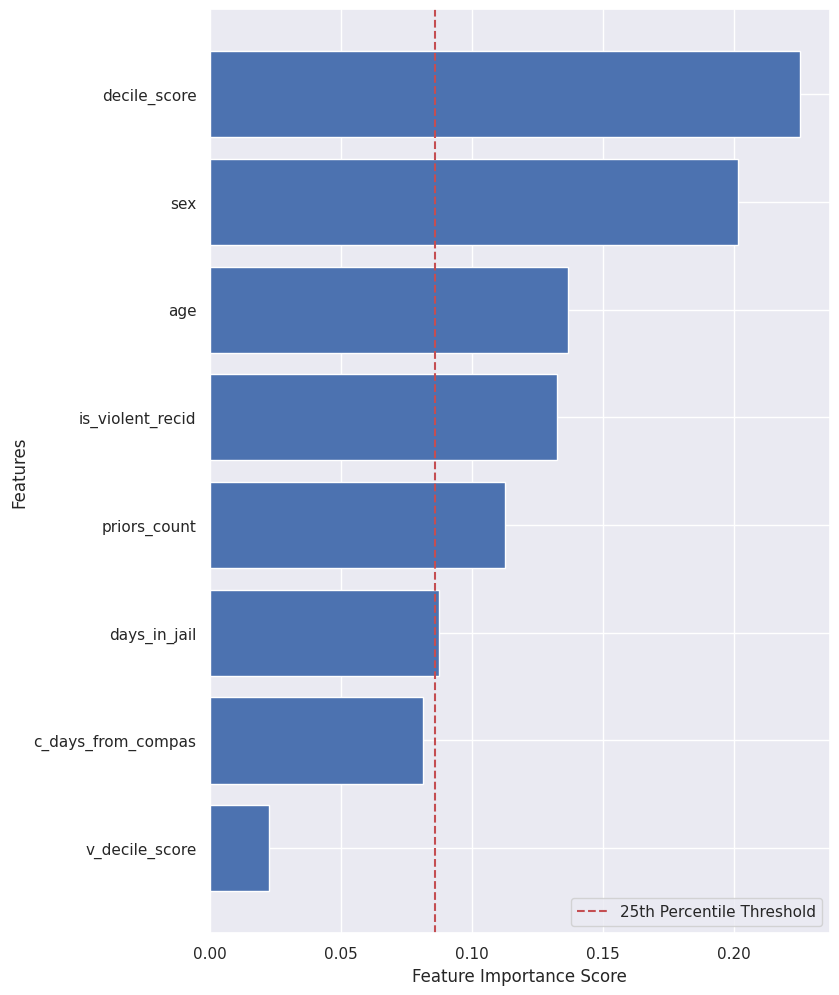

In [184]:
dt_feature_importance = DecisionTreeClassifier()

# fit the model
dt_feature_importance.fit(X_train, y_train)
# get importance
importance = dt_feature_importance.feature_importances_

# Sort features based on importance
sorted_indices = np.argsort(importance)
sorted_features = [df_train.columns[i] for i in sorted_indices]

# Calculate the threshold for the 25th percentile
threshold = np.quantile(importance, 0.25)

# Adjust the figure size
plt.figure(figsize=(8, 12))

# plot feature importance with adjusted bar width
plt.barh(sorted_features, importance[sorted_indices], height=0.8)
plt.axvline(x=threshold, color='r', linestyle='--', label='25th Percentile Threshold')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.legend(loc='lower right')
plt.show()

least_important_features_df = [sorted_features[i] for i in range(len(sorted_features)) if importance[sorted_indices[i]] < threshold]

In [185]:
least_important_features = pd.DataFrame({'Least Importance (DecisionTreeClassifier)' : least_important_features_df})
least_important_features

,Least Importance (DecisionTreeClassifier)
0,v_decile_score
1,c_days_from_compas


### **One-hot encoding**

We perform one-hot encoding through a DictVectorizer instance.
One hot encoding is one method of converting data to prepare it for a machine learning algorithm. With one-hot, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. Each integer value is represented as a binary vector.

In [186]:
dv.get_feature_names_out()

array(['age', 'c_days_from_compas', 'days_in_jail', 'decile_score',
       'is_violent_recid', 'priors_count', 'sex', 'v_decile_score'],
      dtype=object)

**Note on parameter tuning**

During this project we will use GridSearchCV to accelerate the parameter tuning process.
GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid. It’s essentially a cross-validation technique. The model as well as the parameters must be entered.

In [191]:
from sklearn.model_selection import GridSearchCV
import pickle

In [189]:
dt = DecisionTreeClassifier()


params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,  10, 15, 20, 50, 60, None],
              'min_samples_leaf' : [1, 5, 10, 15, 20, 500, 100, 200],
              'criterion' : ['gini', 'entropy', 'log_loss'],
              'random_state': [47]
              }

grid_search_dt = GridSearchCV(estimator=dt, param_grid=params, n_jobs=-1, cv=5)

grid_search_dt.fit(X_train, y_train)

best_params = grid_search_dt.best_params_
best_score = grid_search_dt.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'random_state': 47}
Best score: 0.7962490417282563


In [192]:
with open('DecisionTreeClassifier.bin', 'wb') as f_out:
    pickle.dump((dv, grid_search_dt), f_out)

Validation Score

In [193]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = grid_search_dt.predict(X_val)
dt_accuracy_score = accuracy_score(y_val, y_pred)
dt_accuracy_score

0.8326508326508326

In [194]:
accuracy = np.round(accuracy_score(y_val, y_pred),2)
print(f'Accuracy = {accuracy}')

Accuracy = 0.83


In [195]:
dt_classification_report = classification_report(y_val, y_pred)
print(dt_classification_report)

              precision    recall  f1-score   support

          -1       0.85      0.86      0.85       170
           0       0.86      0.80      0.83      1822
           1       0.80      0.87      0.84      1671

    accuracy                           0.83      3663
   macro avg       0.84      0.84      0.84      3663
weighted avg       0.84      0.83      0.83      3663



In [196]:
dt_confusion_matrix = confusion_matrix(y_val, y_pred)
dt_confusion_matrix

array([[ 146,   15,    9],
       [  24, 1449,  349],
       [   2,  214, 1455]])

Test Score

In [197]:
test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)
y_pred = grid_search_dt.predict(X_test)
accuracy_score(y_test, y_pred)

0.8329694323144105

### Fairness

Fairness constraints

Fairness constraints in the context of machine learning refer to predefined rules or conditions that are imposed to ensure that the model's predictions or decisions do not lead to unfair or discriminatory outcomes across different groups or individuals. These constraints are designed to promote fairness, mitigate biases, and ensure that the model treats all individuals or groups equitably. Here are key considerations related to fairness constraints:

- Definition of Fairness
- Bias Mitigation Techniques
- Explainability and Transparency
- Legal and Ethical Considerations

### Privacy

Differential Privacy

Differential privacy is a mathematical framework for ensuring the privacy of individuals in datasets. It can provide a strong guarantee of privacy by allowing data to be analyzed without revealing sensitive information about any individual in the dataset.

- One of the most commonly used mechanisms to answer numerical questions is the addition of calibrated noise: adding enough noise to the output to mask the contribution of any possible individual in the data while still preserving the overall accuracy of the analysis. One concrete example of adding noise for differential privacy is the Laplace mechanism.

In [214]:
import numpy as np

def laplace_mechanism(data, epsilon):
    # Compute the sensitivity (maximum change in output when adding/removing a single data point)
    sensitivity = 1  # For simplicity, assuming sensitivity of 1

    # Generate Laplace noise
    laplace_noise = np.random.laplace(0, sensitivity / epsilon, len(data))

    # Compute the noisy mean
    noisy_mean = np.mean(data) + np.mean(laplace_noise)

    return noisy_mean

# Ensure that the dataset is a list of numerical values or can be easily converted to such a format for this specific example.
# Example non-numeric dataset
# data = not_numeric_dataset


# Convert the non-numeric dataset to a list of floats
# your_numeric_dataset = [float(value) for value in your_non_numeric_dataset]
data = data_class

# Set the privacy parameter (epsilon)
epsilon = 0.1

# Apply Laplace mechanism to compute differentially private mean
noisy_mean = laplace_mechanism(data, epsilon)

# Print results
print(f"Original Mean: {np.mean(data)}")
print(f"Noisy Mean (Differentially Private): {noisy_mean}")


Original Mean: sex                    0.815298
age                   34.019273
decile_score           4.997052
priors_count           3.913191
c_days_from_compas    54.963584
is_recid               0.414774
is_violent_recid       0.073105
v_decile_score         4.022822
days_in_jail          55.470900
dtype: float64
Noisy Mean (Differentially Private): sex                    0.863762
age                   34.067737
decile_score           5.045516
priors_count           3.961655
c_days_from_compas    55.012048
is_recid               0.463238
is_violent_recid       0.121570
v_decile_score         4.071286
days_in_jail          55.519364
dtype: float64
